C:\Users\user\AppData\Local\Temp\ipykernel_30172\357906566.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_ordonnateurs = features.groupby('Cluster_Name').apply(lambda x: x.nlargest(10, 'montant_total')).reset_index(drop=True)


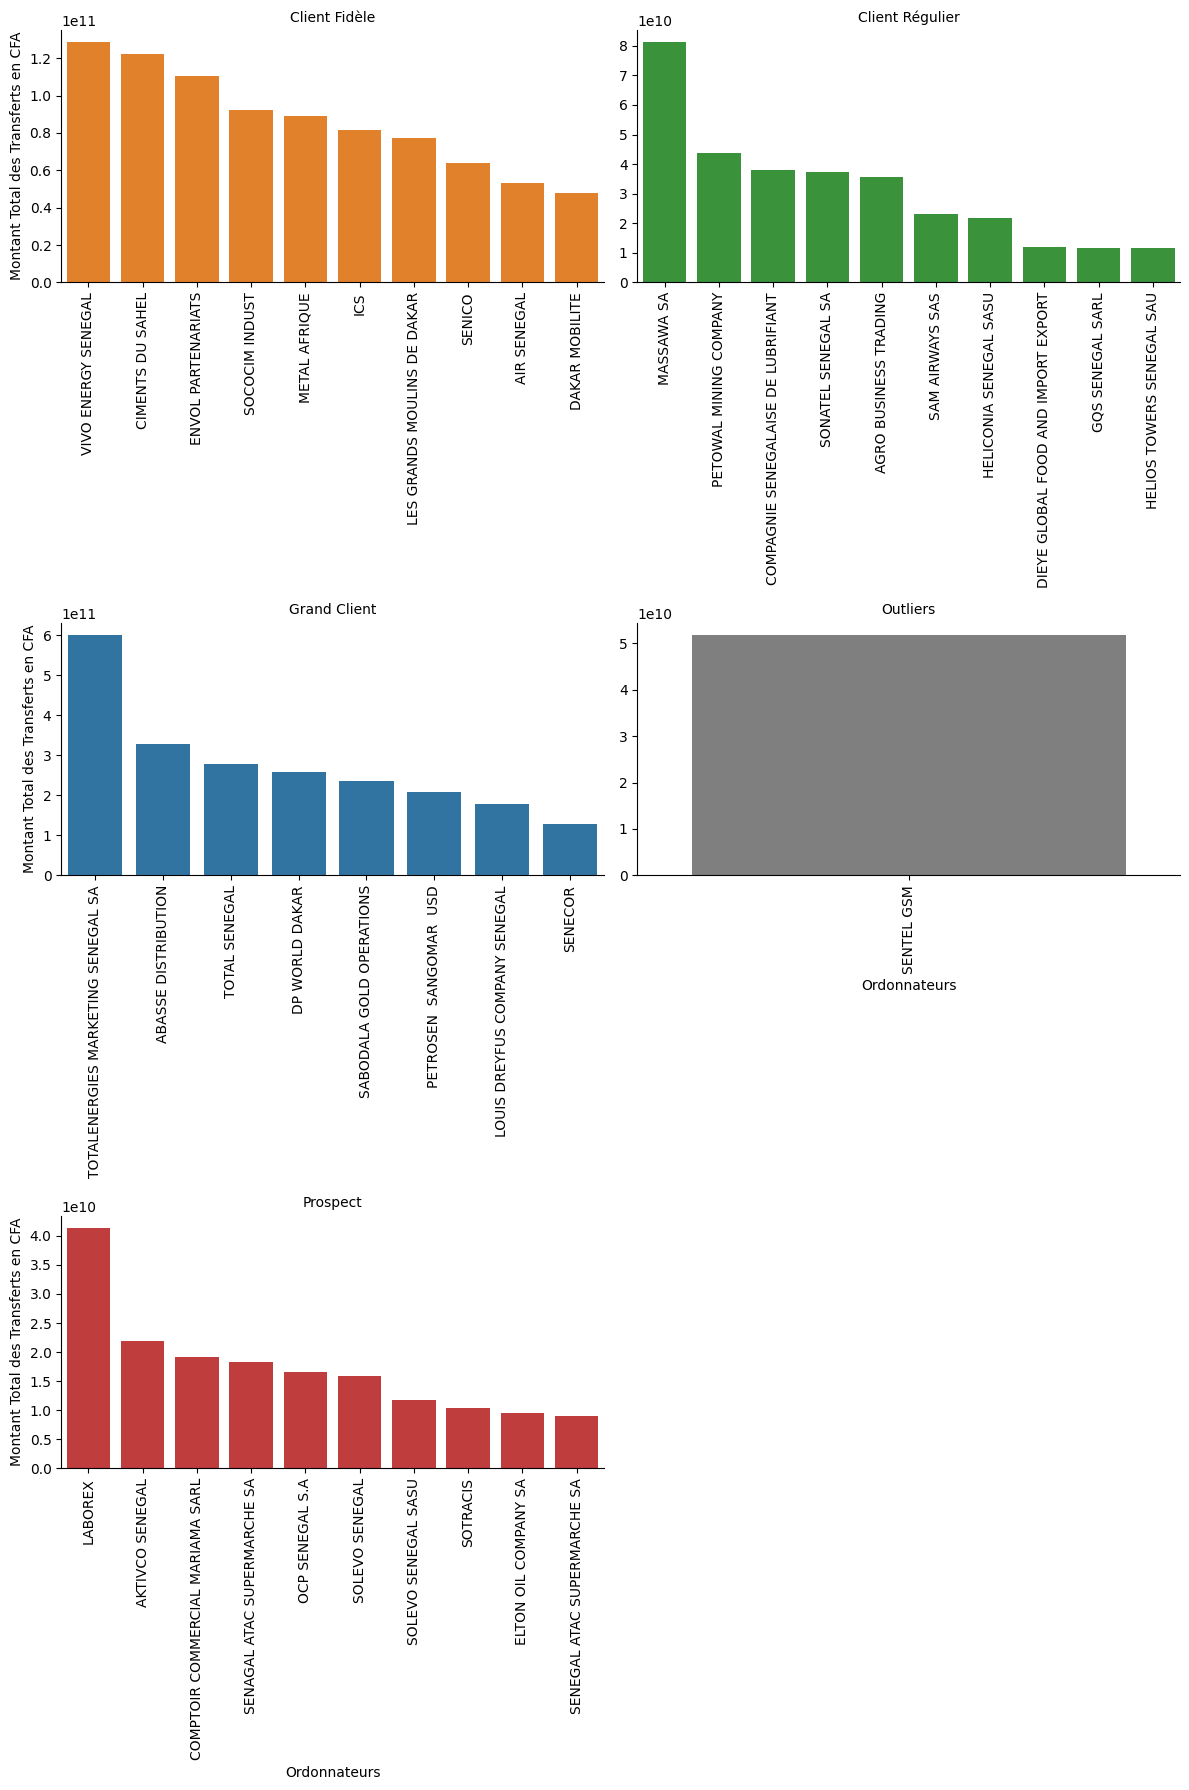

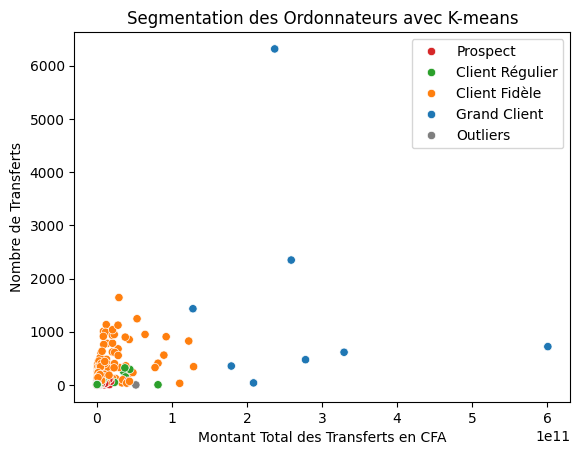

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Étape 1 : Préparation des données
file_path = 'Transfert_ new.csv'
transfert_data = pd.read_csv(file_path, sep=';')
transfert_data.columns = transfert_data.columns.str.strip().str.replace('ï»¿', '')

# Conversion de la colonne des dates en format datetime
transfert_data['dou'] = pd.to_datetime(transfert_data['dou'], format='%d/%m/%Y')

# Calcul des caractéristiques pertinentes pour chaque ordonnateur, y compris le nombre de devises
features = transfert_data.groupby('nomdo').agg(
    montant_total=('mcfa', 'sum'),
    montant_moyen=('mcfa', 'mean'),
    nombre_transferts=('mcfa', 'count'),
    annee_active=('dou', lambda x: x.dt.year.nunique()),
    nombre_devises=('dev', lambda x: x.nunique())
).reset_index()

# Étape 2 : Standardisation des données
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['montant_total', 'montant_moyen', 'nombre_transferts', 'annee_active', 'nombre_devises']])

# Application de K-means pour le clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
features['Cluster'] = clusters

# Renommer les clusters en fonction des caractéristiques observées et ajouter des commentaires
cluster_mapping = {
    0: 'Client Fidèle',  # Montant total moyen élevé, nombre de transferts modéré, nombre de devises moyen
    1: 'Outliers',  # Un seul client avec des caractéristiques exceptionnelles
    2: 'Prospect',  # Montant total moyen bas, nombre de transferts bas, nombre de devises bas
    3: 'Grand Client',  # Montant total moyen extrêmement élevé, nombre de transferts très élevé, nombre de devises élevé
    4: 'Client Régulier'  # Montant total moyen modéré, nombre de transferts modéré, nombre de devises moyen
}

features['Cluster_Name'] = features['Cluster'].map(cluster_mapping)

# Ajouter les commentaires pour chaque cluster
#cluster_comments = {
    #'Client Fidèle': 'Montant total moyen élevé, nombre de transferts modéré, nombre de devises moyen',
    #'Outliers': 'Un seul client avec des caractéristiques exceptionnelles',
    #'Prospect': 'Montant total moyen bas, nombre de transferts bas, nombre de devises bas',
    #'Grand Client': 'Montant total moyen extrêmement élevé, nombre de transferts très élevé, nombre de devises élevé',
    #'Client Régulier': 'Montant total moyen modéré, nombre de transferts modéré, nombre de devises moyen'
#}

#features['Cluster_Comment'] = features['Cluster_Name'].map(cluster_comments)


# Ajouter le nom du gestionnaire
features = features.merge(transfert_data[['nomdo', 'cli']].drop_duplicates(), on='nomdo', how='left')

# Sauvegarder le fichier Excel
output_file_path = 'Client_Segmentation_KMeans.xlsx'
features.to_excel(output_file_path, index=False)

# Identification des top 10 ordonnateurs de chaque segment
top_10_ordonnateurs = features.groupby('Cluster_Name').apply(lambda x: x.nlargest(10, 'montant_total')).reset_index(drop=True)

# Utilisation de couleurs distinctes pour chaque segment
palette = {
    'Prospect': 'tab:red',
    'Client Fidèle': 'tab:orange',
    'Client Régulier': 'tab:green',
    'Grand Client': 'tab:blue',
    'Outliers': 'tab:gray'
}

# Visualisation des top 10 ordonnateurs de chaque segment
g = sns.FacetGrid(top_10_ordonnateurs, col="Cluster_Name", col_wrap=2, sharex=False, sharey=False, height=6, palette=palette)
g.map_dataframe(sns.barplot, x='nomdo', y='montant_total', hue='Cluster_Name', palette=palette, dodge=False)
g.set_axis_labels("Ordonnateurs", "Montant Total des Transferts en CFA")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=90)
plt.tight_layout()
plt.show()

# Visualisation des segments avec couleurs distinctes
sns.scatterplot(data=features, x='montant_total', y='nombre_transferts', hue='Cluster_Name', palette=palette)
plt.xlabel('Montant Total des Transferts en CFA')
plt.ylabel('Nombre de Transferts')
plt.title('Segmentation des Ordonnateurs avec K-means')
plt.legend()
plt.show()
